In [167]:
import pandas as pd
import numpy as np
import datetime, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import random

In [2]:
def get_unix(latency):
    millisecond = datetime.datetime.now() - datetime.timedelta(seconds=latency)
    unixtimestamp = int(millisecond.timestamp() * 1000)
    return unixtimestamp

In [3]:
def plot_data(df, driftsExtra=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(df["latency"], label='Stream')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax1.axvline(i, color='red')
    if driftsExtra:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    
    plt.show()

In [4]:
df = pd.read_csv("conceptdrift/Data/data_drift_20.csv",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'latency': pd.Series(dtype='float'),
                   'drift': pd.Series(dtype='int')})

In [5]:
def isAllowed(driftTime, detectTime, threshold):
    
    tsDrift = datetime.datetime.fromtimestamp(int(driftTime)/1000)  
    tsDetect = datetime.datetime.fromtimestamp(int(detectTime)/1000)  
    diff = tsDetect - tsDrift
    diff = diff.total_seconds()
    if diff > 0 and diff <= threshold:
        return True
    return False
    

In [184]:
def evaluate(threshold, df_p):
    TOTAL_DRIFT= 20
    detectedTS = df_p["ingestion"].tolist()
    driftsTS = df.query("drift == 1")["ingestion"].tolist()

    result= dict()
    result["name"] =  df_p["algorithm"].unique()[0]
    result["predictedDrift"] = len(detectedTS)
    result["accepted"] = 0
    
    
    
    for i in driftsTS:

        for j in detectedTS:
            accept = isAllowed(i, j, threshold)
            if accept:
                result["accepted"] += 1
                break
    
    acc = (result["accepted"]/len(driftsTS))*100
    result["rejected"] = len(detectedTS) -result["accepted"] # false alarm
    result["acc"] = acc
    return result

In [185]:
files = ["result_sudden_ADWIN.csv","result_sudden_GMADM.csv", "result_sudden_CUSUM.csv", "result_sudden_PageHinkley.csv"]

In [214]:
thresholds = [0.75, 1.25, 1.75]
df_result = pd.DataFrame({'algorithm': pd.Series(dtype='str'),'threshold': pd.Series(dtype='int'),
                   'predictedDrift': pd.Series(dtype='int'),'accepted': pd.Series(dtype='int'),'falseAlarm': pd.Series(dtype='int'),'accuracy': pd.Series(dtype='float'), })


for f in files:
    df_processed = pd.read_csv(f"conceptdrift/Data/result/{f}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
    
    
    for t in thresholds:
        result = evaluate(t, df_processed)
        df_result = df_result.append({"algorithm":result["name"] ,"threshold": t, "accuracy": result["acc"],
                                      "accepted":result["accepted"],  "falseAlarm": result["rejected"], "predictedDrift": result["predictedDrift"]},ignore_index=True) 

In [237]:
def print_latex(data):
    data = list(data.to_dict(orient="records"))
    for i in data:
        print(f'{i["algorithm"]}  & {i["threshold"]}  & {i["predictedDrift"]} & {i["accepted"]} & {i["falseAlarm"]} & {i["accuracy"]} \\\ \hline') 

In [238]:
print_latex(df_result)

ADWIN  & 0.75  & 42 & 20 & 22 & 100.0 \\ \hline
ADWIN  & 1.25  & 42 & 20 & 22 & 100.0 \\ \hline
ADWIN  & 1.75  & 42 & 20 & 22 & 100.0 \\ \hline
GMADM  & 0.75  & 4 & 1 & 3 & 5.0 \\ \hline
GMADM  & 1.25  & 4 & 3 & 1 & 15.0 \\ \hline
GMADM  & 1.75  & 4 & 3 & 1 & 15.0 \\ \hline
CUSUM  & 0.75  & 11 & 8 & 3 & 40.0 \\ \hline
CUSUM  & 1.25  & 11 & 10 & 1 & 50.0 \\ \hline
CUSUM  & 1.75  & 11 & 10 & 1 & 50.0 \\ \hline
PageHinkley  & 0.75  & 4 & 1 & 3 & 5.0 \\ \hline
PageHinkley  & 1.25  & 4 & 1 & 3 & 5.0 \\ \hline
PageHinkley  & 1.75  & 4 & 1 & 3 & 5.0 \\ \hline


In [195]:
def plot_drifts(df,  files , save_fig=None):
    fig = plt.figure(figsize=(12,6.5), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 3])
    
    for index, file in enumerate(files):
        df_processed = pd.read_csv(f"conceptdrift/Data/result/{file}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
        ax1 = plt.subplot(gs[index])
        ax1.grid()
        ax1.set_ylabel('latency')
        ax1.plot(df["latency"], label='Stream')

        driftsExtra = df_processed["indexNumber"].tolist()
        """
        drifts= list(df.query("drift == 1").index)
        if len(drifts) > 0:
            for i in drifts:
                ax1.axvline(i, color='red')
        """
        for i in driftsExtra:
            ax1.axvline(i, color='orange')
    plt.xlim([800, 1200])
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

In [196]:
def plot_data(df, driftsExtra=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(df["latency"], label='Stream')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax1.axvline(i, color='red')
    if driftsExtra:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    
    plt.show()

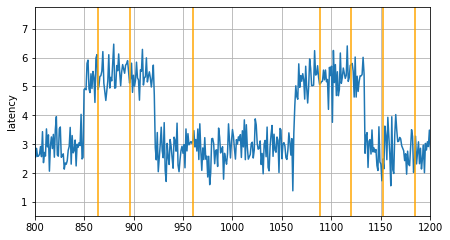

In [197]:
plot_drifts(df,["result_sudden_ADWIN.csv"], "drift_result_plots.png")

In [198]:
def plot_drifts_ex(df,  files , save_fig=None):
    fig = plt.figure(figsize=(12,6.5), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 3])
    
    for index, file in enumerate(files):
        df_processed = pd.read_csv(f"conceptdrift/Data/result/{file}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
        ax1 = plt.subplot(gs[index])
        ax1.grid()
        ax1.set_ylabel('latency')
        ax1.set_xlabel('ingestion unix timestamp')
        ax1.plot(df["ingestion"],df["latency"], label='Stream')

        driftsExtra = df_processed["ingestion"].tolist()
        
        drifts= df.query("drift == 1")
        if drifts.shape[0] > 0:
            for index, row in drifts.iterrows():
                ax1.axvline(int(row["ingestion"]), color='red')
       
        for i in driftsExtra:
            ax1.axvline(int(i), color='orange')
        
    plt.xlim([1658333948701, 1658333951107])
    
    #plt.ylim([0, 7])
    red_patch = mpatches.Patch(color='red', label='actual drift')
    orange_patch = mpatches.Patch(color='orange', label='predicted drift')
    plt.legend(handles=[red_patch,orange_patch])
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

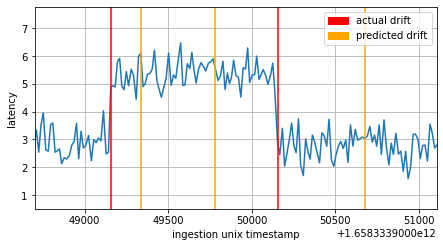

In [199]:
plot_drifts_ex(df,["result_sudden_ADWIN.csv"], "drift_result_adwin_detail.png")